In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/boston-house-prices/housing.csv


In [60]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow_addons.metrics import RSquare 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


In [33]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('/kaggle/input/boston-house-prices/housing.csv', header=None, delimiter=r"\s+", names=column_names)


1) CRIM - per capita crime rate by town 

2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

3) INDUS: proportion of non-retail business acres per town

4) CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

5) NOX: nitric oxides concentration (parts per 10 million)

6) RM: average number of rooms per dwelling

7) AGE: proportion of owner-occupied units built prior to 1940

8) DIS: weighted distances to ﬁve Boston employment centers

9) RAD: index of accessibility to radial highways

10) TAX: full-value property-tax rate per 10,000 doller

11) PTRATIO: pupil-teacher ratio by town

12) B: (1000(Bk−0.63)2) where Bk is the proportion of blacks by

13) LSTAT: % lower status of the population

14) MEDV: Median value of owner-occupied homes in 1000 doller 


<AxesSubplot:>

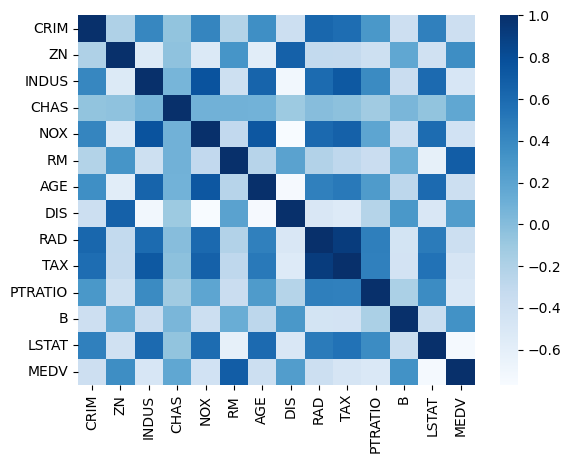

In [34]:
import seaborn as sns
corr_matrix = df.corr()
sns.heatmap(corr_matrix , cmap=plt.cm.Blues)

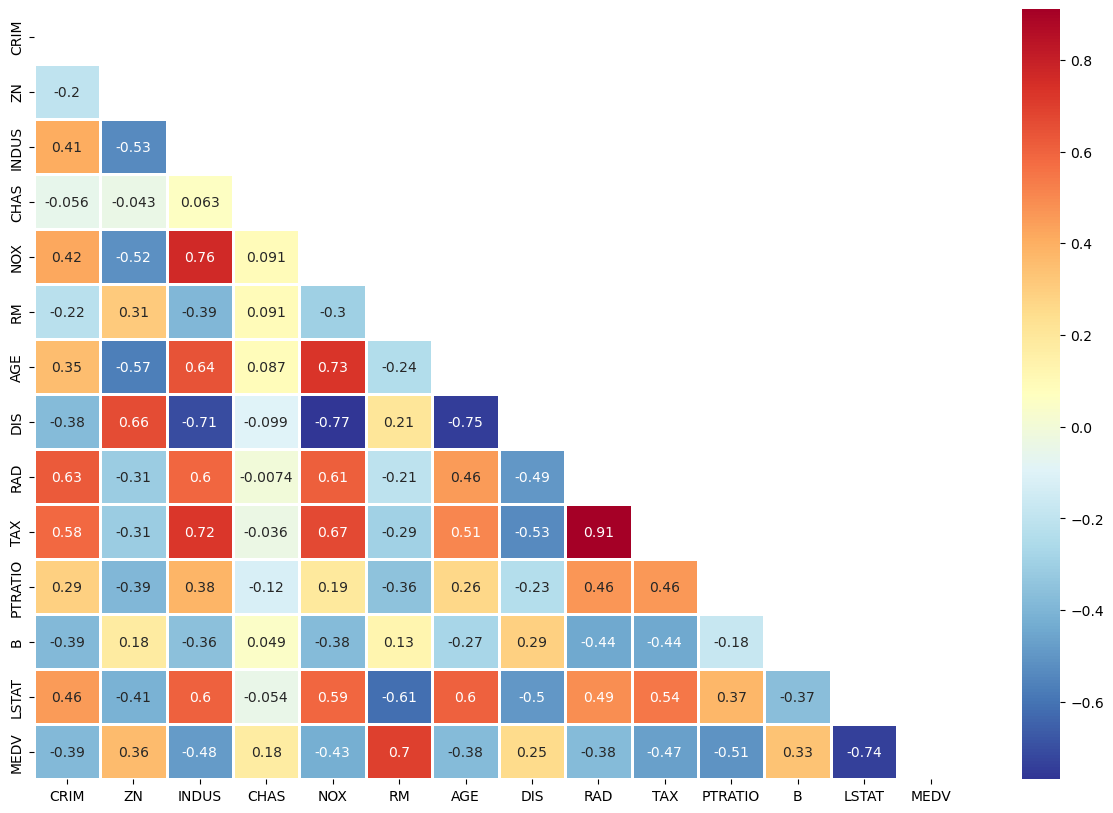

In [35]:
plt.figure(figsize=(15,10))
sns.heatmap(data=df.corr(), mask=np.triu(df.corr()), annot=True, cmap='RdYlBu_r',
           linewidth=1, linecolor='white')
plt.show()

In [36]:
X = df.drop(columns=['MEDV']).values
y = df.MEDV.values
x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.reshape(-1,1))
print(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

[[-0.41978194  0.28482986 -1.2879095  ... -1.45900038  0.44105193
  -1.0755623 ]
 [-0.41733926 -0.48772236 -0.59338101 ... -0.30309415  0.44105193
  -0.49243937]
 [-0.41734159 -0.48772236 -0.59338101 ... -0.30309415  0.39642699
  -1.2087274 ]
 ...
 [-0.41344658 -0.48772236  0.11573841 ...  1.17646583  0.44105193
  -0.98304761]
 [-0.40776407 -0.48772236  0.11573841 ...  1.17646583  0.4032249
  -0.86530163]
 [-0.41500016 -0.48772236  0.11573841 ...  1.17646583  0.44105193
  -0.66905833]]


In [65]:
n_features = X.shape[1]
dropout_proba = 0.25
batch_size = 64
opt = SGD(learning_rate=0.01)
epochs = 10000


In [66]:


def DNN_model_with_dropout(layers_shape, input_dim, dropout_proba, act='relu'):
    inputs = Input(shape=(input_dim,))
    hidden = Dense(layers_shape[0], activation=act)(inputs)
    for i in range(len(layers_shape)-1):
        if dropout_proba > 0:
            hidden = Dropout(dropout_proba)(hidden, training=True)
        hidden = Dense(layers_shape[i+1], activation=act)(hidden)
    if dropout_proba > 0:
        hidden = Dropout(dropout_proba)(hidden, training=True)
    outputs = Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear')(hidden) 
    model = Model(inputs, outputs)
    return model

model = DNN_model_with_dropout([64,32,16],n_features, dropout_proba, act='relu')
model.compile(optimizer = opt,loss="mse",metrics=[RootMeanSquaredError()])
print(model.summary)
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=0)

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f078c0a4f50>>


In [67]:
def DNN_uncertainity(model, x_test,T=500):
    predictions = []
    for _ in range(T):
        predictions += [model.predict(x_test,verbose=0)]    
        #return predictions
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean,std

y_pred, sigma = DNN_uncertainity(model, X_test,T=500)
print("Model score:",r2_score(y_test,y_pred))



Model score: 0.845725371929878


array([0.70306915], dtype=float32)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  """


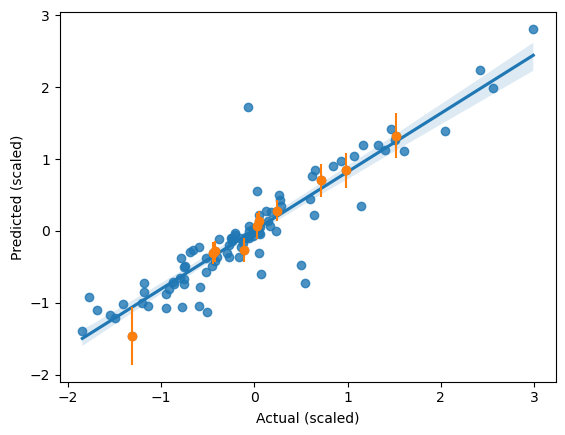

In [80]:
sns.regplot(x=y_test,y=y_pred)
plt.errorbar(y_test[:10],
             y_pred[:10].reshape(-1,),
             yerr=sigma[:10].reshape(-1,),
             linestyle='none',fmt='-o')
plt.xlabel("Actual (scaled)")
plt.ylabel("Predicted (scaled)")
plt.show()

